In [1]:
import os
import wget
import glob 
import datetime
import requests
from bs4 import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Set your working directory 
working_dir = "/Users/cdobson/Documents/Github/profiler_plotting/"
local_log_dir = os.path.join(working_dir, "logs")

# Set deployment start date to weed out burn-in logs
deploy_date = "20220420"

In [3]:
# Get a list of local battery log files
file_list = glob.glob(local_log_dir+"/*Battery.log")
file_list.sort()

# Get a list of remote battery log files
remote_url = "https://rawdata.oceanobservatories.org/files/CP04OSPM/D00016/Battery/"
content = requests.get(remote_url).text
soup = BeautifulSoup(content, 'html.parser')
log_urls = [remote_url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(".log")]

# Rsync any remote log files we don't have yet
local_log_names = [file.split("/")[-1] for file in file_list]
for log in log_urls:
    log_name = log.split("/")[-1]
    log_date = log_name.split(".")[0]
    if log_name not in local_log_names and log_date >= deploy_date:
        print("\nDownloading log file "+log_name)
        download_log = wget.download(log, local_log_dir)

In [4]:
# If a csv with the data already exists then load it into a dataFrame
# Otherwise create it

# Name of your battery data mini database
dsFile = "CP04OSPM-00016_Battery_Data.csv"

# If the file does exist
if dsFile in os.listdir(working_dir):
    # Load it into a dataframe and create a list of the log files we already processed
    mainDF = pd.read_csv(working_dir+dsFile, delimiter=',')
    processed_logs = list(set(mainDF.Log_File.unique()))
    processed_logs.sort()

    # Drop all lines where the log file is equal to the most recent one
    # This allows processing on the go
    most_recent_log = processed_logs[-1]
    mainDF.drop(mainDF.index[mainDF['Log_File'] == most_recent_log], inplace=True)
    
    # Re-assign procesed logs now that we dropped the most recent
    processed_logs = list(set(mainDF.Log_File.unique()))
    processed_logs.sort()
    
# If the file does not exist
else:
    # Create an empty data frame and empty list if the file does not exist 
    mainDF = pd.DataFrame()
    processed_logs = []

In [5]:
# Iterate through each local battery log file to process it
for file in file_list:
    log_file = file.split("/")[-1]
    # We have a list of already processed log files
    # If the file is NOT in the list of already processed files, then proceed
    if log_file not in processed_logs:
        # Open the log file
        print("Parsing the data from log file: "+log_file+" and adding it to the dataframe.")
        with open(file, newline='', encoding='latin-1') as log_file:
            # Read in the text from the log file and parse it into a list
            file_text = log_file.read()
            line_list = file_text.split("\n")
            line_list = line_list[2:len(line_list)-2]

            # Create empty lists to temporarily store values parsed from each 
            # line of the log file text
            log_list = []
            date_list = []
            time_list = []
            datetime_list = []
            battery_num_list = []
            temperature_list = []
            voltage_list = []
            milliamps_list = []
            avg_milliamps_list = []
            
            # Iterate through each line of the log file text
            for line in line_list:
                # Proceed only if the DLOGP text is NOT in the line
                if "DLOGP" not in line:
                    # Parse out and store the data fields we care about in the temporary lists
                    log_list.append(file.split("/")[-1])
                    split_line = line.split(" ")
                    date_list.append(split_line[0])
                    time_list.append(split_line[1])
                    battery_num_list.append(split_line[2])
                    temperature_list.append(float(split_line[10])/100) # Converting temperature
                    voltage_list.append(int(split_line[11])/1000) # Conversion from millivolts to Volts
                    milliamps_list.append(float(split_line[12])) 
                    avg_milliamps_list.append(split_line[13])
    
                    # Generate a datetime object based on the date and time field and store it
                    date = split_line[0]
                    year = int(date.split("/")[0])
                    month = int(date.split("/")[1])
                    day = int(date.split("/")[2])

                    time = split_line[1]
                    hour = int(time.split(":")[0])
                    minute = int(time.split(":")[1])
                    second = int(float(time.split(":")[2]))
                    
                    # Fixes bug found on 8/11 where seconds where greater than 60
                    if second > 59:
                        print("We encountered a second value greater than 59 in file "+file)
                        print("Hour: "+str(hour)+" Minute: "+str(minute)+" Second: "+str(second))
                        second = 59
                    
                    line_datetime = datetime.datetime(year, month, day, hour, minute, second)
                    datetime_list.append(line_datetime)
            
            
            # Create a temporary dataFrame to store the parsed data
            temp_df = pd.DataFrame({ "Log_File": log_list,
                                   "Date": date_list, 
                                   "Time": time_list, 
                                   "Datetime": datetime_list,
                                   "Battery_Number": battery_num_list, 
                                   "Temperature": temperature_list, 
                                   "Voltage": voltage_list,
                                   "Milliamps": milliamps_list, 
                                   "Avg_Milliamps": avg_milliamps_list})
                    
        # Append the temporary dataFrame to the main dataFrame
        mainDF = mainDF.append(temp_df)
            
# Save the dataFrame with the newly appended data as a csv
mainDF['Datetime'] = mainDF['Datetime'].astype('datetime64[ns]')
mainDF.to_csv(working_dir+dsFile, index=False)

Parsing the data from log file: 20220818.Battery.log and adding it to the dataframe.


In [6]:
##### ALL CODE ABOVE THIS BLOCK DEALS WITH PARSING THE LOG FILES TO EXTRACT DATA AND STORE IT #####

##### ALL CODE BELOW THIS BLOCK DEALS WITH CREATING PLOTS WITH THE DATA ##### 

In [7]:
# Load the csv into a dataframe to begin plotting
mainDF = pd.read_csv(working_dir+dsFile, delimiter=',')

# Sort the dataframe by datetime
mainDF = mainDF.sort_values(by=['Datetime'])

# Cast the datetime coloumn as type datetime rather than string
mainDF['Datetime'] = mainDF['Datetime'].astype('datetime64[ns]')

# Flag filter to delete lines for batteries #10, #11, #12 which were not present
mainDF = mainDF[mainDF['Temperature'] > 1]

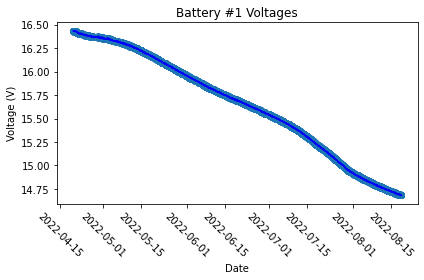

In [8]:
##### PLOT 1: Plotting Voltage for a specific battery #####
# User set battery number to plot
batt_num = 1
batt_num_string = str(batt_num)

# You can modify this threshold to exclude outliers
voltage_threshold = 1

# Slice the dataFrame to include only data for this battery
batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]

# Slice the dataFrame to include only Voltages above the threshold
batt_df = batt_df[batt_df['Voltage']>voltage_threshold]

# Make the plot
plt.cla()
plt.clf()
plt.scatter(batt_df['Datetime'], batt_df['Voltage'], label="Battery #"+batt_num_string+" Voltage")
plt.plot(batt_df['Datetime'], batt_df['Voltage'], 'b-', label="Battery #"+batt_num_string+" Voltage")

# Modify the plot parameters
plt.xticks(rotation=-45)
plt.title("Battery #"+str(batt_num)+" Voltages")
plt.ylabel("Voltage (V)")
plt.xlabel("Date")
plt.tight_layout()
#plt.savefig("Battery_#"+batt_num_string+"_Voltage.png")

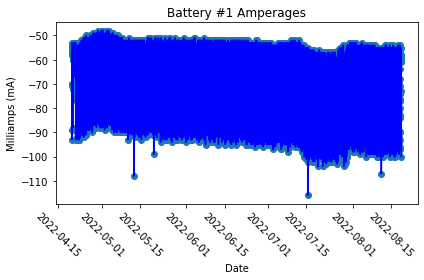

In [9]:
##### PLOT 2: Plotting Amperage for a specific battery #####
# User set battery number to plot
batt_num = 1
batt_num_string = str(batt_num)

# You can modify this threshold to exclude outliers
amps_threshold = 1

# Slice the dataFrame to include only data for this battery
batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]

# Slice the dataFrame to include only Voltages above the threshold
batt_df = batt_df[batt_df['Milliamps']<amps_threshold]

# Make the plot
plt.scatter(batt_df['Datetime'], batt_df['Milliamps'], label="Battery #"+batt_num_string+" Amperage")
plt.plot(batt_df['Datetime'], batt_df['Milliamps'], 'b-', label="Battery #"+batt_num_string+" Amperage")

# Modify the plot parameters
plt.xticks(rotation=-45)
plt.title("Battery #"+str(batt_num)+" Amperages")
plt.ylabel("Milliamps (mA)")
plt.xlabel("Date")
plt.tight_layout()

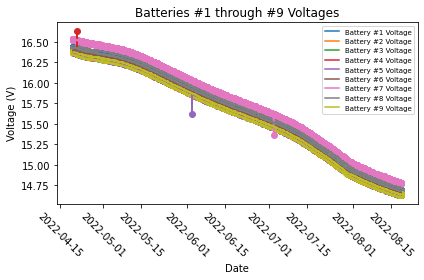

In [10]:
##### PLOT 3: Plotting voltages for all batteries #####

# You can modify this threshold to exclude outliers
voltage_threshold = 1

# Iterate through the battery numbers specified to plot them

# We can iterate through all batteries or a specific list
batt_nums_to_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#batt_nums_to_plot = [1, 8, 5, 6]

for batt_num in batt_nums_to_plot:
    # Generate the battery # string
    batt_num_string = str(batt_num)
    
    # Slice the dataFrame to include only data for this battery
    batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]
    
    # Slice the dataFrame to include only Voltages above the threshold
    batt_df = batt_df[batt_df['Voltage'] > voltage_threshold]

    # Make the plot
    plot_label = "Battery #"+str(batt_num)+" Voltage"
    plt.scatter(batt_df['Datetime'], batt_df['Voltage'])
    plt.plot(batt_df['Datetime'], batt_df['Voltage'], label=plot_label)
    
    # Modify the plot parameters
    plt.xticks(rotation=-45)
    plt.title("Batteries #1 through #9 Voltages")
    plt.ylabel("Voltage (V)")
    plt.xlabel("Date")
    plt.legend(loc="upper right", prop={'size': 7})
    plt.tight_layout()

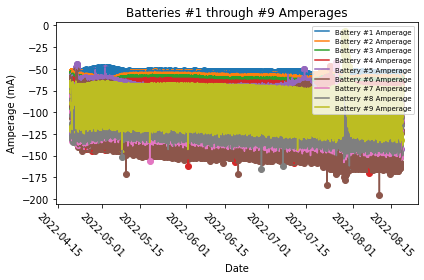

In [11]:
##### PLOT 4: Plotting Amperage for all batteries #####

# You can modify this threshold to exclude outliers
amperage_threshold = 1

# Iterate through the battery numbers specified to plot them

# We can iterate through all batteries or a specific list
batt_nums_to_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#batt_nums_to_plot = [1, 8, 5, 6]

for batt_num in batt_nums_to_plot:
    # Generate the battery # string
    batt_num_string = str(batt_num)
    
    # Slice the dataFrame to include only data for this battery
    batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]
    
    # Slice the dataFrame to include only Voltages above the threshold
    batt_df = batt_df[batt_df['Milliamps'] < amperage_threshold]

    # Make the plot
    plot_label = "Battery #"+str(batt_num)+" Amperage"
    plt.scatter(batt_df['Datetime'], batt_df['Milliamps'])
    plt.plot(batt_df['Datetime'], batt_df['Milliamps'], label=plot_label)
    
    # Modify the plot parameters
    plt.xticks(rotation=-45)
    plt.title("Batteries #1 through #9 Amperages")
    plt.ylabel("Amperage (mA)")
    plt.xlabel("Date")
    plt.legend(loc="upper right", prop={'size': 7})
    plt.tight_layout()

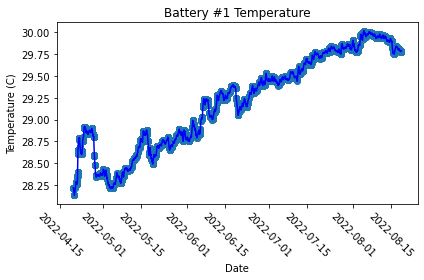

In [12]:
##### PLOT 5: Plotting Temperature for a specific battery #####
# User set battery number to plot
batt_num = 1
batt_num_string = str(batt_num)

# You can modify this threshold to exclude outliers
temperature_threshold = 10

# Slice the dataFrame to include only data for this battery
batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]

# Slice the dataFrame to include only Voltages above the threshold
batt_df = batt_df[batt_df['Temperature']>temperature_threshold]

# Make the plot
plt.cla()
plt.clf()
plt.scatter(batt_df['Datetime'], batt_df['Temperature'], label="Battery #"+batt_num_string+" Temperature")
plt.plot(batt_df['Datetime'], batt_df['Temperature'], 'b-', label="Battery #"+batt_num_string+" Temperature")

# Modify the plot parameters
plt.xticks(rotation=-45)
plt.title("Battery #"+str(batt_num)+" Temperature")
plt.ylabel("Temperature (C)")
plt.xlabel("Date")
plt.tight_layout()

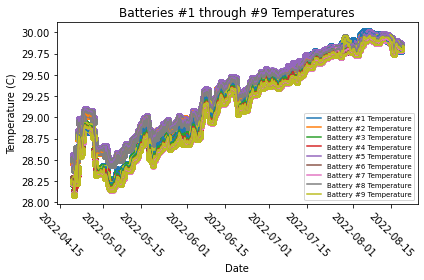

In [13]:
##### PLOT 6: Plotting Temperature for all batteries #####

# You can modify this threshold to exclude outliers
temperature_threshold = 10

# Iterate through the battery numbers specified to plot them

# We can iterate through all batteries or a specific list
batt_nums_to_plot = [1, 2, 3, 4, 5, 6, 7, 8, 9]
#batt_nums_to_plot = [1, 8, 5, 6]

for batt_num in batt_nums_to_plot:
    # Generate the battery # string
    batt_num_string = str(batt_num)
    
    # Slice the dataFrame to include only data for this battery
    batt_df = mainDF[mainDF['Battery_Number'] == "#"+str(batt_num)]
    
    # Slice the dataFrame to include only Voltages above the threshold
    batt_df = batt_df[batt_df['Temperature'] > temperature_threshold]

    # Make the plot
    plot_label = "Battery #"+str(batt_num)+" Temperature"
    plt.scatter(batt_df['Datetime'], batt_df['Temperature'])
    plt.plot(batt_df['Datetime'], batt_df['Temperature'], label=plot_label)
    
    # Modify the plot parameters
    plt.xticks(rotation=-45)
    plt.title("Batteries #1 through #9 Temperatures")
    plt.ylabel("Temperature (C)")
    plt.xlabel("Date")
    plt.legend(loc="lower right", prop={'size': 7})
    plt.tight_layout()